This notebook needs to have the hovernet previously done on the WSIs and just use the results to analysis them.

In [1]:
import warnings
import scipy.io
import json
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import pandas as pd
import sys
import seaborn as sns
warnings.filterwarnings("ignore")
path_folder = '/nfs/home/users/fshahi/Projects/Datasets/large_ndpis/tiled/'
filenames_5x = os.listdir(path_folder)
main_path = '/mnt/cephfs/sharedscratch/users/fshahi/Projects/Histomorphological-Phenotype-Learning'
sys.path.append(main_path)

from models.clustering.data_processing import *
figure_path = '{}/workflow/figures/hovernet/'.format(main_path)
if not os.path.exists(figure_path): os.makedirs(figure_path, exist_ok=True)



In [2]:
groupby = 'leiden_2.0'
meta_folder = '750K'
dataset = 'Meso'
fold_number = 4

h5_complete_path   = '{}/results/BarlowTwins_3/{}/h224_w224_n3_zdim128/hdf5_{}_he_complete_filtered_metadata.h5'.format(main_path, dataset, dataset)
adata_train, h5ad_path = read_h5ad_reference(h5_complete_path, meta_folder, groupby, fold_number)

Matching the tiles between 20X and 5X

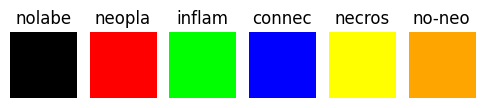

In [3]:
# from: https://github.com/vqdang/hover_net/blob/master/type_info.json
color_dict = {
    "0" : ["nolabe", [0  ,   0,   0]], 
    "1" : ["neopla", [255,   0,   0]], 
    "2" : ["inflam", [0  , 255,   0]], 
    "3" : ["connec", [0  ,   0, 255]], 
    "4" : ["necros", [255, 255,   0]], 
    "5" : ["no-neo", [255, 165,   0]] 
}

fig, ax = plt.subplots(1,6, figsize=(6,1))
for i in range(0,6):
    color = color_dict[str(i)][1]
    label = color_dict[str(i)][0]
    ax[i].imshow(np.array(color).reshape(1,1,3))
    ax[i].set_title(label)
    ax[i].axis('off')
plt.show()

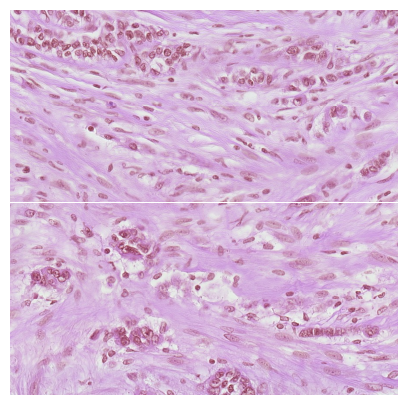

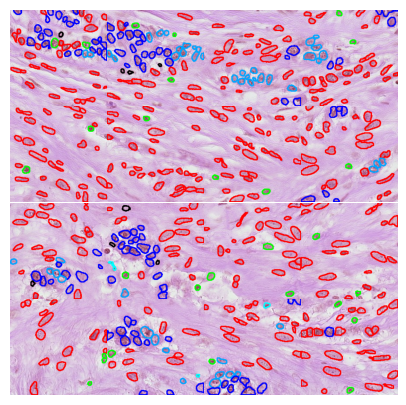

In [7]:
fig1, ax1 = plt.subplots(4,4, figsize=(5,5))
fig2, ax2 = plt.subplots(4,4, figsize=(5,5))

#  make the space between the plots to zero
fig1.subplots_adjust(hspace=0, wspace=0)
fig2.subplots_adjust(hspace=0, wspace=0)

# off the grids
for ax in ax1.flat:
    ax.axis('off')
for ax in ax2.flat:
    ax.axis('off')

i_5x, j_5x = 36,27
start_i, start_j = i_5x*4, j_5x*4


for i in range(start_i, start_i+4):
    for j in range(start_j, start_j+4):
        try:
            folder, format_ = 'overlay', 'png'
            path = '/nfs/home/users/fshahi/Projects/Datasets/large_ndpis/hovernet/MESO_277_6_files/20.0/overlay/{}_{}.png'.format(i,j)
            overlay = cv2.imread(path)

            # load the original image
            path = '/nfs/home/users/fshahi/Projects/Datasets/large_ndpis/tiled/MESO_277_6_files/20.0/{}_{}.jpeg'.format(i, j)
            image = cv2.imread(path)

            i_plot = i-start_i
            j_plot = j-start_j

            ax1[j_plot, i_plot].imshow(image)
            ax2[j_plot, i_plot].imshow(overlay)
        except:
            pass

plt.show()
fig1.savefig('{}/original_tile.png'.format(figure_path))
fig2.savefig('{}/overlay_tile.png'.format(figure_path))


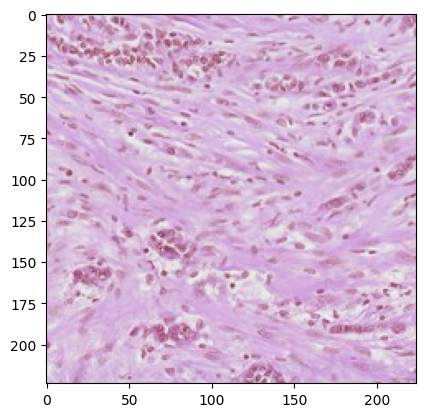

In [192]:
# show the 5x version of the image
path = '/nfs/home/users/fshahi/Projects/Datasets/large_ndpis/tiled/MESO_277_6_files/5.0/{}_{}.jpeg'.format(i_5x, j_5x)
image = cv2.imread(path)
plt.imshow(image)
plt.show()

#### Color Guidence

In [201]:
path_folder = '/nfs/home/users/fshahi/Projects/Datasets/large_ndpis/tiled/'
filenames_5x = os.listdir(path_folder)

nuc_types = dict()
for filename in filenames_5x[:1]:
    nuc_types[filename] = dict()
    tiles = os.listdir(path_folder + filename + '/5.0/')
    for tile in tiles[:1]:
        start_i_5x, start_j_5x = tile.split('.jpeg')[0].split('_')
        start_i, start_j = int(start_i_5x)*4, int(start_j_5x)*4
        nuc_types[filename][tile] = dict()
        for i in range(start_i, start_i+4):
            for j in range(start_j, start_j+4):
                try:
                    path = '/nfs/home/users/fshahi/Projects/Datasets/large_ndpis/hovernet/{}/20.0/json/{}_{}.json'.format(filename,i,j)
                    json_file = open(path)
                    data = json.load(json_file)
                    for i_nuc in data['nuc']:
                        type_index = str(data['nuc'][i_nuc]['type'])
                        nuc_type_key = color_dict[type_index][0]
                        nuc_types[filename][tile][nuc_type_key] = nuc_types[filename][tile].get(nuc_type_key, 0) + 1
                except:
                    pass

nuc_types

{'MESO_277_6_files': {'36_27.jpeg': {'neopla': 103,
   'connec': 328,
   'nolabe': 8,
   'inflam': 28,
   'no-neo': 50,
   'necros': 3}}}

In [5]:
# path_folder = '/nfs/home/users/fshahi/Projects/Datasets/large_ndpis/tiled/'
# filenames_5x = os.listdir(path_folder)

# nuc_types_df = pd.DataFrame(columns=['slides', 'tiles', 'necros', 'neopla', 'inflam', 'connec', 'no-neo', 'nolabe'])
# for filename in filenames_5x[:-1]:
#     tiles = os.listdir(path_folder + filename + '/5.0/')
#     for tile in tiles:
#         start_i_5x, start_j_5x = tile.split('.jpeg')[0].split('_')
#         start_i, start_j = int(start_j_5x)*4, int(start_i_5x)*4
#         row = pd.DataFrame([[filename, tile, 0, 0, 0, 0, 0, 0]], columns=['slides', 'tiles', 'necros', 'neopla', 'inflam', 'connec', 'no-neo', 'nolabe'])
#         for i in range(start_i, start_i+4):
#             for j in range(start_j, start_j+4):
#                 try:
#                     path = '/nfs/home/users/fshahi/Projects/Datasets/large_ndpis/hovernet/{}/20.0/json/{}_{}.json'.format(filename,i,j)
#                     json_file = open(path)
#                     data = json.load(json_file)
#                     for i_nuc in data['nuc']:
#                         type_index = str(data['nuc'][i_nuc]['type'])
#                         nuc_type_key = color_dict[type_index][0]
#                         row[nuc_type_key] = row[nuc_type_key] + 1
#                 except:
#                     pass
#         nuc_types_df = pd.concat([nuc_types_df, row], axis=0)


# nuc_types_df

In [3]:
nuc_types_df = pd.read_csv('/nfs/home/users/fshahi/Projects/Datasets/large_ndpis/tiled/nuc_types_full.csv')
nuc_types_df.columns = ['slides', 'tiles', 'necrosis', 'neoplastic', 'inflammation', 'connective', 'no-neo', 'nolabe']
nuc_types_df.groupby('slides').sum().reset_index()


,slides,tiles,necrosis,neoplastic,inflammation,connective,no-neo,nolabe
0,MESO_113_25_files,40_21.jpeg41_18.jpeg28_12.jpeg39_8.jpeg32_28.j...,28497,62481,14868,128620,24544,3658
1,MESO_118_11_files,36_2.jpeg40_21.jpeg38_13.jpeg37_13.jpeg27_24.j...,0,0,0,0,0,0
2,MESO_119_18_files,21_40.jpeg36_27.jpeg18_15.jpeg16_37.jpeg40_21....,0,0,0,0,0,0
3,MESO_126_31_files,18_15.jpeg48_18.jpeg48_22.jpeg13_30.jpeg21_11....,0,0,0,0,0,0
4,MESO_126_41_files,48_18.jpeg48_22.jpeg18_29.jpeg15_30.jpeg45_39....,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
83,MESO_466_7_files,21_40.jpeg36_2.jpeg32_44.jpeg24_42.jpeg34_43.j...,1859814,15416016,2428140,4028046,9213864,772794
84,MESO_81_19_files,43_4.jpeg4_40.jpeg36_2.jpeg32_44.jpeg36_27.jpe...,701250,570225,411000,887100,145650,33375
85,MESO_81_25_files,21_40.jpeg43_4.jpeg54_6.jpeg4_40.jpeg36_2.jpeg...,5808359,39893756,3988180,3709532,1918206,1357067
86,MESO_92_16_files,36_2.jpeg36_27.jpeg18_15.jpeg16_37.jpeg40_21.j...,1010556,4200876,2310876,2313684,4567752,195318


In [221]:
# fetch clusters
csv = '/nfs/home/users/fshahi/Projects/Histomorphological-Phenotype-Learning/results/BarlowTwins_3/Meso/h224_w224_n3_zdim128/750K/adatas/Meso_he_complete_filtered_metadata_leiden_2p0__fold4.csv'
clusters = pd.read_csv(csv)
clusters = clusters[['tiles', 'leiden_2.0', 'slides']]
clusters['slides'] = clusters['slides'].apply(lambda x: x+'_files') # add _files to the slides to match dictionary
clusters = clusters[clusters['slides'].isin(filenames_5x)] # filter out the slides that are in the dictionary
print('Number of clusters:',clusters['leiden_2.0'].value_counts().shape[0])
print('Number of slides:',clusters['slides'].value_counts().shape[0])

# merge the dataframes
df = nuc_types_df.merge(clusters, on=['slides', 'tiles'], how='inner')
print('Number of clusters:',df['leiden_2.0'].value_counts().shape[0])
print('Number of slides:',df['slides'].value_counts().shape[0])
df

Number of clusters: 47
Number of slides: 895
Number of clusters: 47
Number of slides: 175


,slides,tiles,necrosis,neoplastic,inflammation,connective,no-neo,nolabe,leiden_2.0
0,MESO_277_6_files,18_15.jpeg,5,406,9,200,1,8,39
1,MESO_277_6_files,18_15.jpeg,5,406,9,200,1,8,39
2,MESO_277_6_files,18_15.jpeg,5,406,9,200,1,8,39
3,MESO_277_6_files,18_15.jpeg,5,406,9,200,1,8,39
4,MESO_277_6_files,18_15.jpeg,5,406,9,200,1,8,39
...,...,...,...,...,...,...,...,...,...
14534275,MESO_267_22_files,35_5.jpeg,0,0,0,0,0,0,14
14534276,MESO_267_22_files,16_3.jpeg,0,0,0,0,0,0,14
14534277,MESO_267_22_files,19_4.jpeg,0,0,0,0,0,0,44
14534278,MESO_267_22_files,22_17.jpeg,11,293,82,130,139,13,44


Group By Slides DataFrame by Clusters

In [1]:
ls -lh '/nfs/home/users/fshahi/Projects/Histomorphological-Phenotype-Learning/results/BarlowTwins_3/Meso/h224_w224_n3_zdim128/750K/'

total 168M
drwxrwxr-x 2 fshahi domain users  332 Aug  8 10:19 adatas/
drwxr-xr-x 3 fshahi domain users    6 Aug 14 17:28 alpha_5.0/
drwxr-xr-x 2 fshahi domain users    5 Jul 26 14:11 cph_0.05_0.1/
drwxr-xr-x 5 fshahi domain users    4 May 15 11:03 leiden_1p0_fold0/
drwxr-xr-x 5 fshahi domain users    4 May 23 14:13 leiden_1p0_fold4/
drwxr-xr-x 5 fshahi domain users    4 May 23 12:09 leiden_1p5_fold0/
drwxr-xr-x 5 fshahi domain users    4 May 23 14:32 leiden_1p5_fold4/
drwxr-xr-x 5 fshahi domain users    4 May  4 11:47 leiden_2p0_fold0/
drwxr-xr-x 6 fshahi domain users    6 Jul 14 13:42 leiden_2p0_fold4/
drwxr-xr-x 5 fshahi domain users    4 May 23 12:17 leiden_2p5_fold0/
drwxr-xr-x 5 fshahi domain users    4 May 23 14:37 leiden_2p5_fold4/
drwxr-xr-x 5 fshahi domain users    4 May 15 10:06 leiden_3p0_fold0/
drwxr-xr-x 5 fshahi domain users    4 May 23 14:41 leiden_3p0_fold4/
drwxr-xr-x 5 fshahi domain users    4 May 16 10:19 leiden_4p0_fold0/
drwxr-xr-x 5 fshahi domain users    4 May 23

In [3]:
df = pd.read_csv('/nfs/home/users/fshahi/Projects/Datasets/large_ndpis/tiled/nuc_types_full.csv')
# df.groupby('slides').sum().reset_index()
df

,MESO_277_6_files,36_27.jpeg,16,410,24,229,34,9
0,MESO_277_6_files,18_15.jpeg,5,406,9,200,1,8
1,MESO_277_6_files,14_6.jpeg,0,0,0,0,0,0
2,MESO_277_6_files,16_37.jpeg,14,149,14,310,19,6
3,MESO_277_6_files,40_21.jpeg,0,0,0,0,0,0
4,MESO_277_6_files,13_30.jpeg,3,117,22,431,5,8
...,...,...,...,...,...,...,...,...
350275436,MESO_81_34_files,16_3.jpeg,0,0,0,0,0,0
350275437,MESO_81_34_files,19_4.jpeg,0,0,0,0,0,0
350275438,MESO_81_34_files,22_17.jpeg,66,873,39,27,12,25
350275439,MESO_81_34_files,26_36.jpeg,72,966,41,17,102,30


In [15]:
plotting_dfs = pd.read_csv('/nfs/home/users/fshahi/Projects/Histomorphological-Phenotype-Learning/results/BarlowTwins_3/Meso/h224_w224_n3_zdim128/750K/nuc_types_hovernet_clusters.csv')
plotting_dfs

,leiden_2.0,tiles,necrosis,neoplastic,inflammation,connective,no-neo,nolabe,mean_inflammation,mean_necrosis,mean_connective
0,0,16186,366016,1591601,570440,1090979,861529,82697,35.242802,22.613122,67.402632
1,1,4099,101131,317235,212289,213249,140645,17444,51.790437,24.672115,52.024640
2,2,12086,596923,777839,664132,950975,660742,52049,54.950521,49.389624,78.684015
3,3,15170,192458,693970,374788,882140,391070,38021,24.705867,12.686750,58.150297
4,4,21190,241887,832353,464605,1040945,642022,42413,21.925672,11.415149,49.124351
5,5,10279,479406,546648,441717,608707,394959,33423,42.972760,46.639362,59.218504
6,6,6103,203279,704115,271520,342498,410853,35808,44.489595,33.308045,56.119613
7,7,14196,640740,2217158,1160688,996861,1701823,131991,81.761623,45.135249,70.221260
8,8,22578,336481,2575620,881925,1868163,1115609,108015,39.061254,14.903047,82.742626
9,9,720,27468,42598,21562,29721,20181,2041,29.947222,38.150000,41.279167


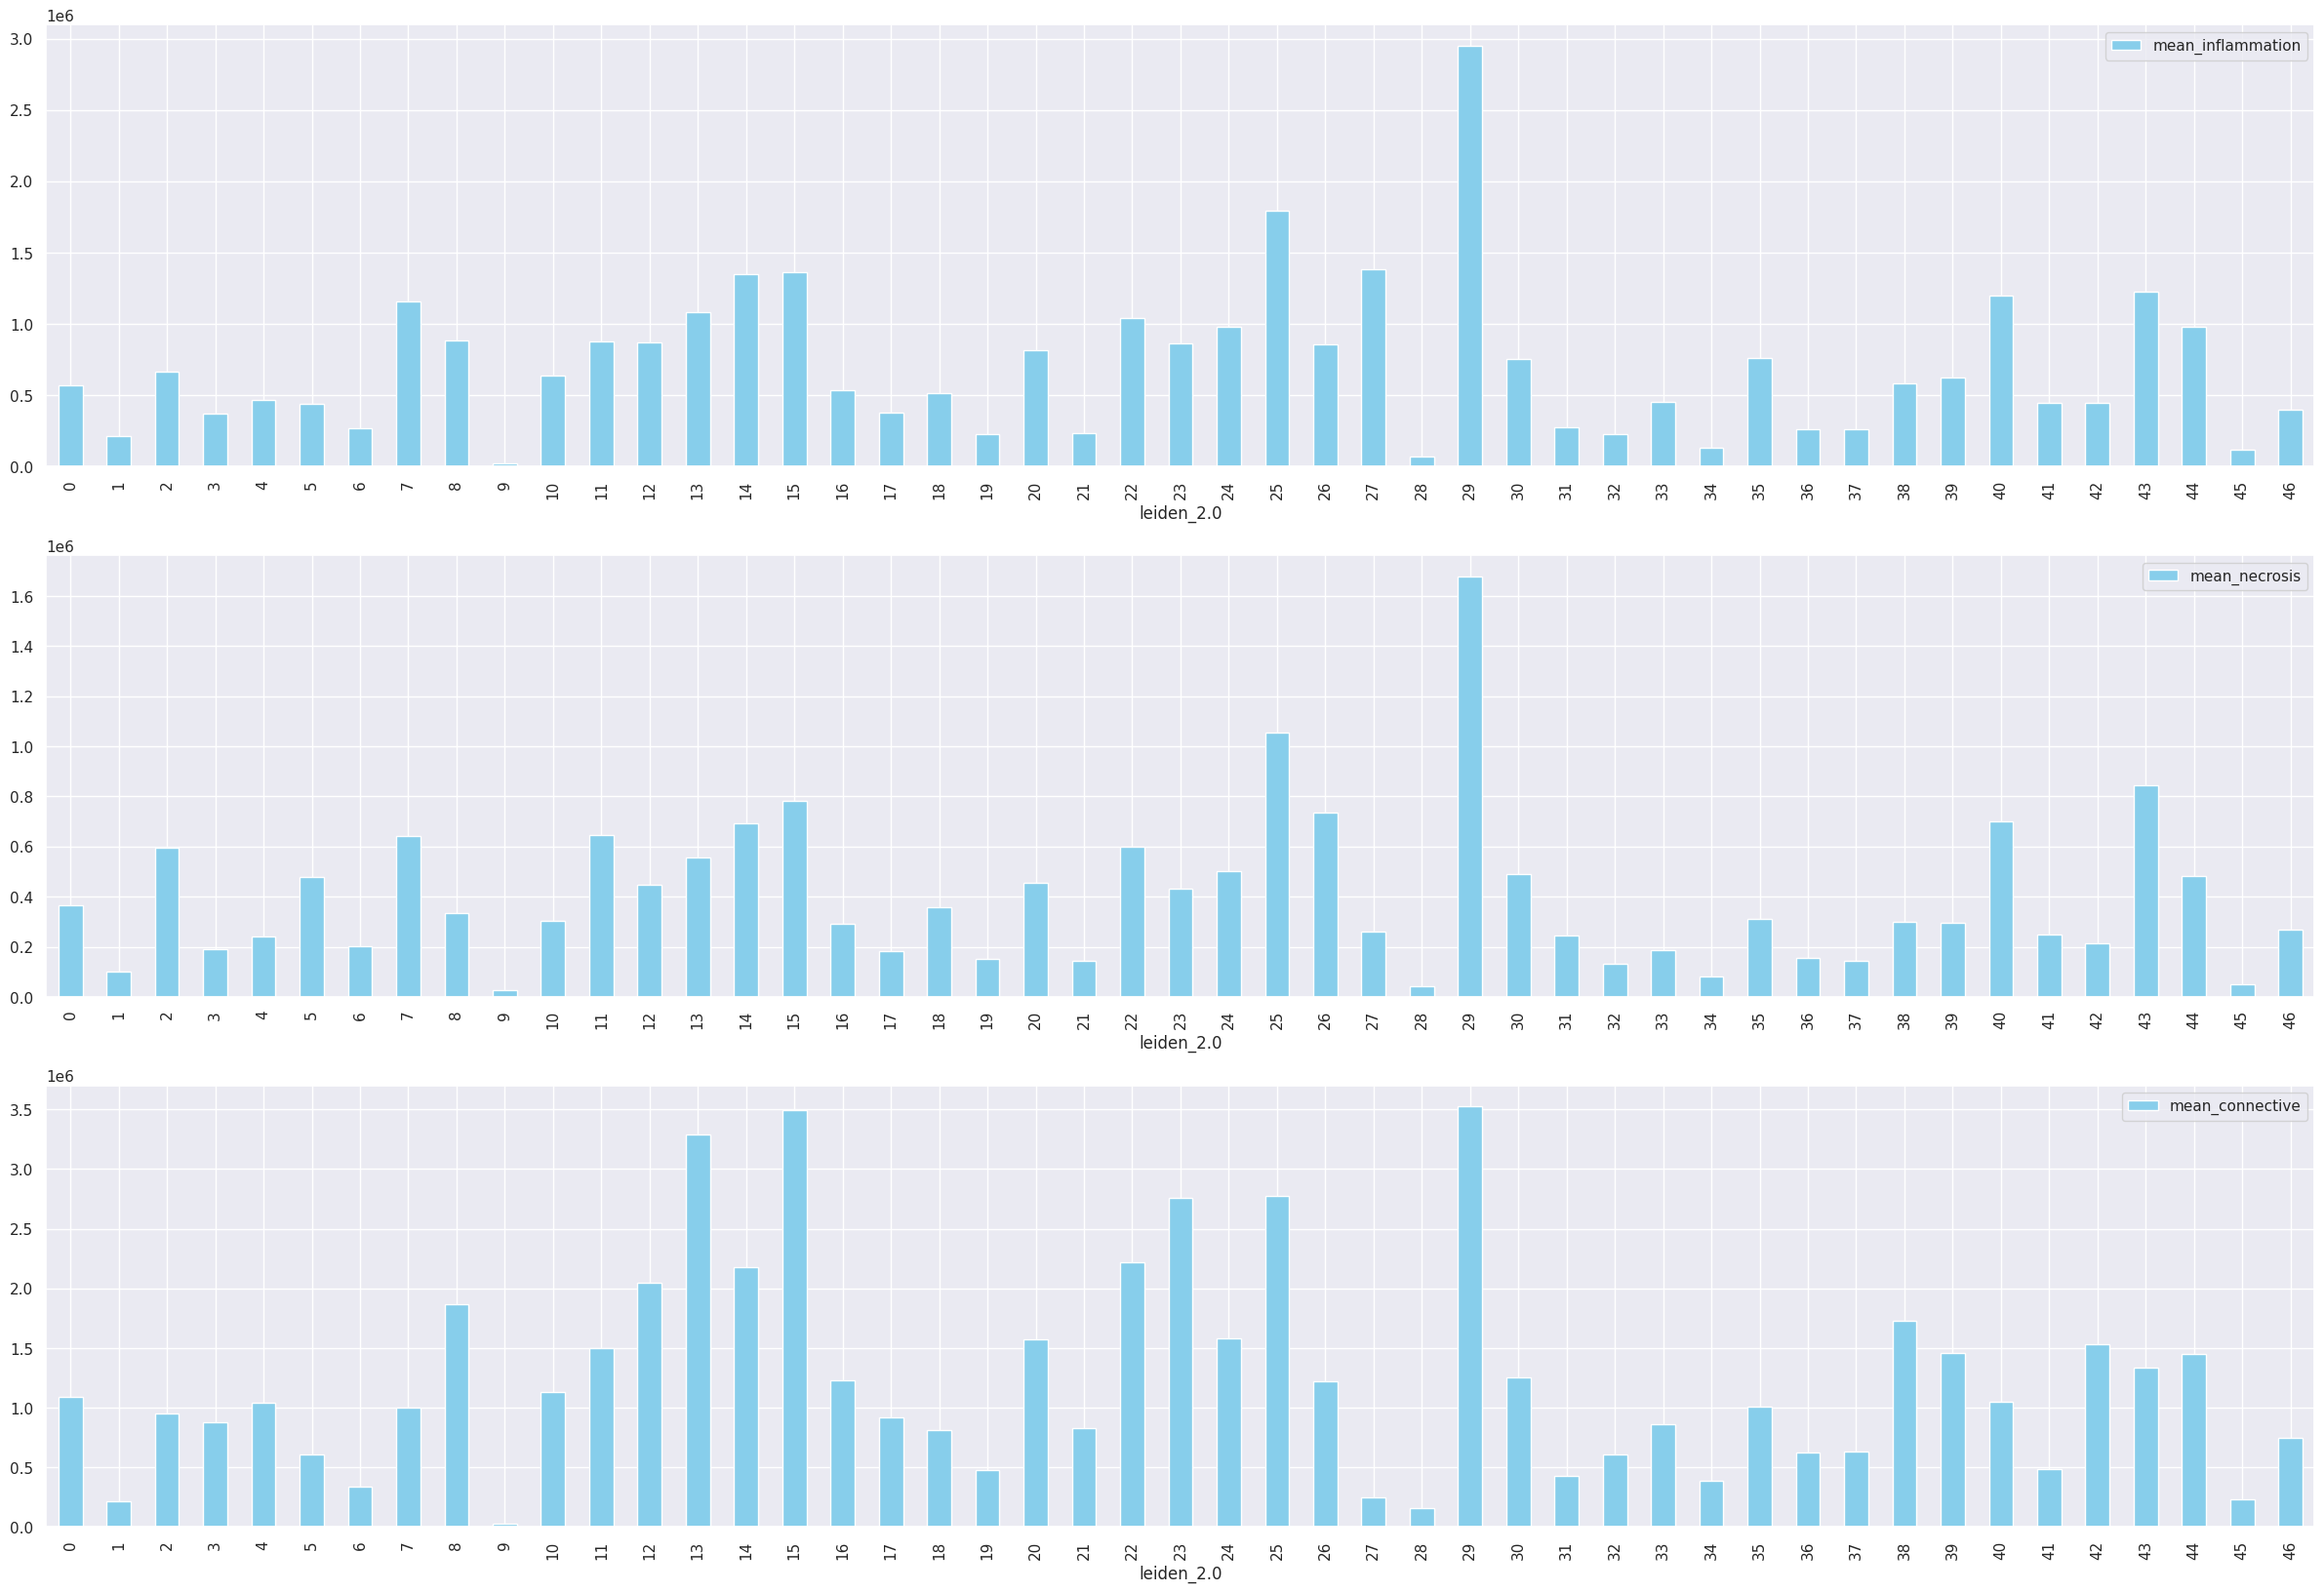

In [19]:
# plotting_dfs = df.drop('slides', axis=1)
sns.set(style="darkgrid")
plotting_dfs = plotting_dfs.groupby('leiden_2.0')
tiles_per_cluster = [len(plotting_dfs.get_group(i)) for i in plotting_dfs.groups]
plotting_dfs = plotting_dfs.sum()
plotting_dfs['tiles'] = tiles_per_cluster
plotting_dfs['mean_inflammation'] = plotting_dfs['inflammation']/plotting_dfs['tiles']
plotting_dfs['mean_necrosis'] = plotting_dfs['necrosis']/plotting_dfs['tiles']
plotting_dfs['mean_connective'] = plotting_dfs['connective']/plotting_dfs['tiles']
plotting_dfs = plotting_dfs.reset_index()
temp = plotting_dfs[['mean_inflammation', 'mean_necrosis', 'mean_connective', 'leiden_2.0']]

# plot each column of the dataframe
fig, ax = plt.subplots(3,1, figsize=(30,20))
ax = ax.flatten()
for i, col in enumerate(['mean_inflammation', 'mean_necrosis', 'mean_connective']):
    temp.plot(x='leiden_2.0', y=col, kind='bar', ax=ax[i], color='skyblue')

Get Pictures For Top Clusters (For the next figure legend)

In [20]:
top_5_inflammation = temp.sort_values(by='mean_inflammation', ascending=False).head(5)
top_5_necrosis = temp.sort_values(by='mean_necrosis', ascending=False).head(4)
top_5_connective = temp.sort_values(by='mean_connective', ascending=False).head(4)


im_list_dict = dict()
for class_ in ['mean_inflammation', 'mean_necrosis', 'mean_connective']:
    im_list = []
    if class_ == 'mean_inflammation': cluster_set = top_5_inflammation['leiden_2.0'].astype(str).tolist()
    elif class_ == 'mean_necrosis': cluster_set = top_5_necrosis['leiden_2.0'].astype(str).tolist()
    elif class_ == 'mean_connective': cluster_set = top_5_connective['leiden_2.0'].astype(str).tolist()
    for cluster_number in cluster_set:
        indexes, sets = adata_train[adata_train.obs[groupby] == cluster_number].obs['indexes'], adata_train[adata_train.obs[groupby] == cluster_number].obs['original_set']
        i_rand = np.random.randint(0, len(indexes))
        index_ = indexes[i_rand]
        set_ = sets[i_rand]
        if set_ == 'valid': set_address = 'validation' 
        else: set_address = set_
        h5_image_path = h5_complete_path.split('results/')[0] + 'datasets/{}/he/patches_h224_w224/hdf5_Meso_he_{}.h5'.format('Meso', set_address)
        h5_image = h5py.File(h5_image_path, 'r')
        im_list.append((h5_image['{}_img'.format(set_)][int(index_)], cluster_number))
        h5_image.close()
    im_list_dict[class_] = im_list

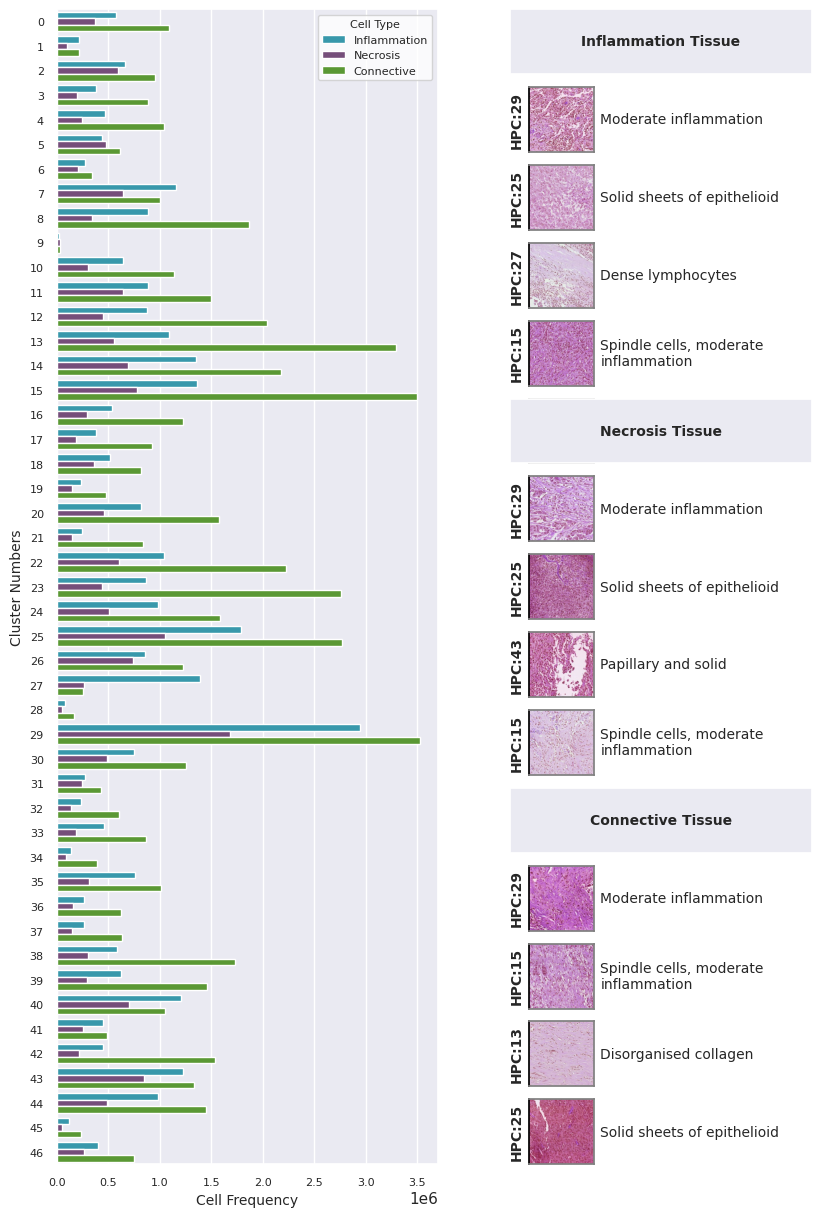

In [21]:
ncol, nrow = 10, 15
fig = plt.figure(figsize=(ncol, nrow))
gs = fig.add_gridspec(nrow, ncol)
j = 5
ax = fig.add_subplot(gs[0:15,0:j])
sns.set_theme(style="whitegrid")
test_data_melted = pd.melt(temp, id_vars='leiden_2.0',var_name="Cell Type", value_name="Cell Frequency")
test_data_melted["Cell Type"] = test_data_melted["Cell Type"].str.replace('mean_', '').str.capitalize()
colors = ["#25a5be", "#7b4682", "#56a923"]
ax = sns.barplot(y='leiden_2.0', x="Cell Frequency", hue="Cell Type",data=test_data_melted, palette=colors, orient='h', ax=ax)
ax.tick_params(labelsize=8)
ax.legend(title='Cell Type', title_fontsize='8', fontsize='8')
ax.set_xlabel("Cell Frequency",fontsize=10)
ax.set_ylabel("Cluster Numbers",fontsize=10)


import textwrap
sns.set_style("dark")
annotations = pd.read_csv('{}/files/meso_annotations_750K.csv'.format(main_path), index_col=0).reset_index()

for class_ in ['mean_inflammation', 'mean_necrosis', 'mean_connective']:
    im_list = im_list_dict[class_]
    if class_ == 'mean_inflammation':
        title = 'Inflammation Tissue'
        i = 0
    elif class_ == 'mean_necrosis':
        title = 'Necrosis Tissue'
        i = 5
    elif class_ == 'mean_connective':
        title = 'Connective Tissue'
        i = 10

    ax = fig.add_subplot(gs[i,j+1:])
    ax.set(xticks=[], yticks=[])
    ax.text(.5, 0.5, textwrap.fill(title, 30), fontsize=10, ha='center', va='center', weight='bold')
    pos = ax.get_position()
    ax.set_position([pos.x0-.02, pos.y0, pos.width, pos.height])
    i += 1

    for (image, cluster_number) in im_list:

        ax = fig.add_subplot(gs[i, j:])
        if image is not None:
            ax.imshow(image)
        else:
            cluster_number = cluster_number.split('_')[0]
        ax.set(xticks=[], yticks=[])
        i += 1

        ax.set_ylabel('HPC:{}'.format(cluster_number), fontdict=dict(weight='bold', size=10))
        ax.set_axis_on()
        ax.spines['left'].set_color('black')
        ax.spines['right'].set_color('gray')
        ax.spines['top'].set_color('gray')
        ax.spines['bottom'].set_color('gray')
        pos = ax.get_position()
        ax.set_position([pos.x0-.08, pos.y0, pos.width, pos.height])


        annotation_text = textwrap.fill(annotations[annotations['HPC']==int(cluster_number)]['Summary'].values[0], 30)
        label_text = annotation_text
        ax.text(1.1, .5, label_text,
                    transform=ax.transAxes,
                    horizontalalignment="left", verticalalignment="center", size="small", )
plt.show()

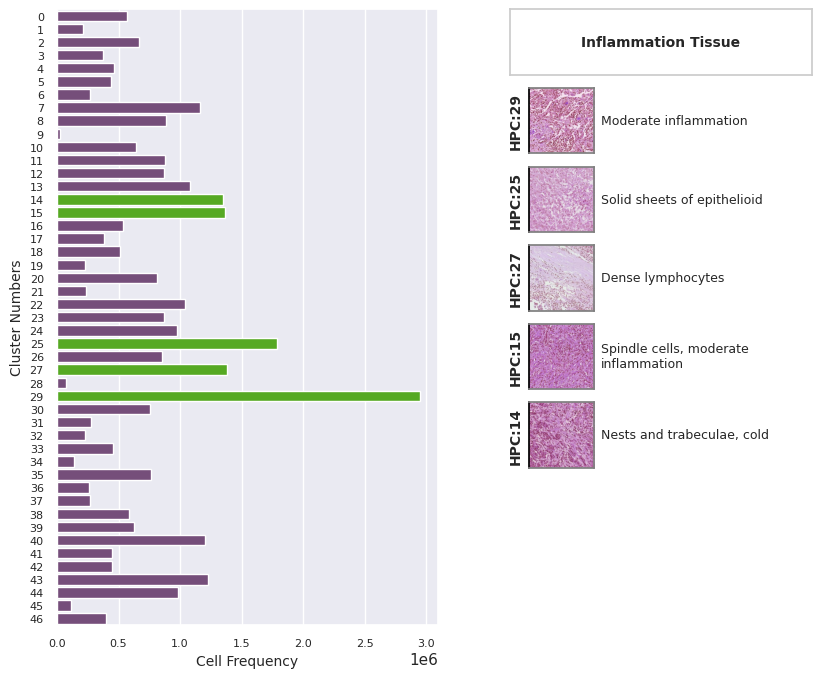

In [24]:
ncol, nrow = 10, 8
fig = plt.figure(figsize=(ncol, nrow))
gs = fig.add_gridspec(nrow, ncol)
j = 5
im_list = im_list_dict['mean_inflammation']
hpc_list = [int(im_list[i][1]) for i in range(0,len(im_list))]



ax = fig.add_subplot(gs[0:15,0:j])
sns.set_theme(style="whitegrid")
ax = sns.barplot(y='leiden_2.0', x="mean_inflammation",data=temp, orient='h', color='#7b4682', ax=ax)

# change the color of three specific clusters
for ind in hpc_list:
    ax.patches[ind].set_facecolor("#56a923")
ax.tick_params(labelsize=8)
ax.set_xlabel("Cell Frequency",fontsize=10)
ax.set_ylabel("Cluster Numbers",fontsize=10)


import textwrap
annotations = pd.read_csv('{}/files/meso_annotations_750K.csv'.format(main_path), index_col=0).reset_index()
title = 'Inflammation Tissue'
i = 0
ax = fig.add_subplot(gs[i,j+1:])
ax.set(xticks=[], yticks=[])
ax.text(.5, 0.5, textwrap.fill(title, 30), fontsize=10, ha='center', va='center', weight='bold')
pos = ax.get_position()
ax.set_position([pos.x0-.02, pos.y0, pos.width, pos.height])
i += 1

for (image, cluster_number) in im_list:

    ax = fig.add_subplot(gs[i, j:])
    if image is not None:
        ax.imshow(image)
    else:
        cluster_number = cluster_number.split('_')[0]
    ax.set(xticks=[], yticks=[])
    i += 1

    ax.set_ylabel('HPC:{}'.format(cluster_number), fontdict=dict(weight='bold', size=10))
    ax.set_axis_on()
    ax.spines['left'].set_color('black')
    ax.spines['right'].set_color('gray')
    ax.spines['top'].set_color('gray')
    ax.spines['bottom'].set_color('gray')
    pos = ax.get_position()
    ax.set_position([pos.x0-.08, pos.y0, pos.width, pos.height])


    annotation_text = textwrap.fill(annotations[annotations['HPC']==int(cluster_number)]['Summary'].values[0], 30)
    label_text = annotation_text
    ax.text(1.1, .5, label_text,
                transform=ax.transAxes,
                horizontalalignment="left", verticalalignment="center", size="9" )
plt.show()
# fig.savefig('{}/inflammation_tissue.png'.format(figure_path))

